In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress h5py deprecation warning

import numpy as np
import datetime

import os
import backtrader as bt
import backtrader.indicators as btind

from gym import spaces
from btgym.spaces import DictSpace

from btgym import BTgymEnv, BTgymDataset
from btgym.strategy.base import BTgymBaseStrategy
from btgym.strategy.utils import tanh

from btgym.algorithms import Launcher, A3C, AacStackedRL2Policy

from btgym.strategy.observers import Reward, Position, NormPnL


import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

from statsmodels.tsa.stattools import adfuller

DATA_BIAS = 1e-5

In [2]:
# Episodic data generating utils:
class SignalProvider():
    
    def __init__(self, env):
        self.env = env
        self.done = True
        self.sample_config = dict(
            episode_config=dict(
                get_new=True,
                sample_type=0,
                b_alpha=1.0,
                b_beta=1.0
            ),
            trial_config=dict(
                get_new=True,
                sample_type=0,
                b_alpha=1.0,
                b_beta=1.0
            )
        )
    
    def get_batch(self, batch_size):
        obs_list = []
        #batch_int = []
        batch_r = []
        batch_i = []
        while len(batch_r) < batch_size:
            if not self.done:
                o, r, self.done, i = env.step(self.env.get_initial_action())
            else:
                o = env.reset()
                r = 0
                i = None
                self.done = False
            #obs_list.append(o['raw_state'])
            #obs_list.append(o['external'])
            #batch_int.append(o['internal'])
            #batch_r.append(r)
            #batch_i.append(i)
        return obs_list
    
    def get_episode(self, sample_type=0):
        self.sample_config['episode_config']['sample_type'] = sample_type
        self.sample_config['trial_config']['sample_type'] = sample_type
        self.done = False
        _ = env.reset(**self.sample_config)
        obs_list = []
        batch_r = []
        batch_i = []
        while not self.done:
            o, r, self.done, i = env.step(self.env.action_space.sample())
            obs_list.append(o)
            
        batch_obs = {key: [] for key in o.keys()}
        
        for obs in obs_list:
            for k, v in obs.items():
                batch_obs[k].append(v)
                
        return batch_obs
    
    def close(self):
        self.env.close()
        self.done = True
  


In [3]:
# Strategy for spread trading

class CryptoSpreadStrat_0(BTgymBaseStrategy):
    """

    """

    # Time embedding period:
    time_dim = 30 

    # Number of environment steps to skip before returning next response,
    # e.g. if set to 10 -- agent will interact with environment every 10th step;
    # every other step agent action is assumed to be 'hold':
    skip_frame = 1

    # Number of timesteps reward estimation statistics are averaged over, should be:
    # skip_frame_period <= avg_period <= time_embedding_period:
    avg_period = time_dim

    # Possible agent actions:
    portfolio_actions = ('hold', 'buy', 'sell', 'close')
    #portfolio_actions = ('hold', 'open', 'close')

    params = dict(
        # Note: fake `Width` dimension to use 2d conv etc.:
        state_shape=
            {
                'external': spaces.Box(low=-1, high=1, shape=(time_dim, 1, 10), dtype=np.float32),
                'internal': spaces.Box(low=-2, high=2, shape=(avg_period, 1, 5), dtype=np.float32),
                'metadata': DictSpace(
                    {
                        'type': spaces.Box(
                            shape=(),
                            low=0,
                            high=1,
                            dtype=np.uint32
                        ),
                        'trial_num': spaces.Box(
                            shape=(),
                            low=0,
                            high=10**10,
                            dtype=np.uint32
                        ),
                        'trial_type': spaces.Box(
                            shape=(),
                            low=0,
                            high=1,
                            dtype=np.uint32
                        ),
                        'sample_num': spaces.Box(
                            shape=(),
                            low=0,
                            high=10**10,
                            dtype=np.uint32
                        ),
                        'first_row': spaces.Box(
                            shape=(),
                            low=0,
                            high=10**10,
                            dtype=np.uint32
                        ),
                        'timestamp': spaces.Box(
                            shape=(),
                            low=0,
                            high=np.finfo(np.float64).max,
                            dtype=np.float64
                        ),
                    }
                )
            },
        cash_name='default_cash',
        asset_names=['default_asset'],
        start_cash=None,
        commission=0.0025,
        leverage=1.0,
        drawdown_call=5,
        target_call=19,
        portfolio_actions=portfolio_actions,
        initial_action=None,
        initial_portfolio_action=None,
        skip_frame=skip_frame,
        state_ext_scale=2e3,
        state_int_scale=1.0, 
        metadata={}
    )

    def __init__(self, **kwargs):
        """

        Args:
            **kwargs:   see BTgymBaseStrategy args.
        """
        super(CryptoSpreadStrat_0, self).__init__(**kwargs)
        self.state['metadata'] = self.metadata

    def set_datalines(self):
        self.data.high = self.data.low = self.data.close = self.data.open
        
        self.data.sma_2 = btind.SimpleMovingAverage(self.data.open, period=2)
        self.data.sma_4 = btind.SimpleMovingAverage(self.data.open, period=4)
        self.data.sma_8 = btind.SimpleMovingAverage(self.data.open, period=8)
        self.data.sma_16 = btind.SimpleMovingAverage(self.data.open, period=16)
        self.data.sma_32 = btind.SimpleMovingAverage(self.data.open, period=32)
        self.data.sma_64 = btind.SimpleMovingAverage(self.data.open, period=64)
        self.data.sma_128 = btind.SimpleMovingAverage(self.data.open, period=128)

        self.data.dim_sma = btind.SimpleMovingAverage(
            self.datas[0],
            period=(128 + self.time_dim)
        )
        self.data.dim_sma.plotinfo.plot = False

    def get_external_state(self):

        x = np.stack(
            [
                np.ones(self.time_dim) * DATA_BIAS,
                np.frombuffer(self.data.open.get(size=self.time_dim)),
                np.frombuffer(self.data.sma_2.get(size=self.time_dim)),
                np.frombuffer(self.data.sma_4.get(size=self.time_dim)),
                np.frombuffer(self.data.sma_8.get(size=self.time_dim)),
                np.frombuffer(self.data.sma_16.get(size=self.time_dim)),
                np.frombuffer(self.data.sma_32.get(size=self.time_dim)),
                np.frombuffer(self.data.sma_64.get(size=self.time_dim)),
                np.frombuffer(self.data.sma_128.get(size=self.time_dim)),
                np.ones(self.time_dim) * DATA_BIAS,
            ],
            axis=-1
        )
        # Gradient along features axis:
        x = np.gradient(x, axis=1) 

        # Amplify and squash in [-1,1], seems to be best option as of 4.10.17:
        # `self.p.state_ext_scale` param is supposed to keep most of the signal
        # in 'linear' part of tanh while squashing spikes.

        x_market = tanh(x * self.p.state_ext_scale)

        return x_market[:, None, :]
    
    def get_internal_state(self):

        x_broker = np.concatenate(
            [
                np.asarray(self.broker_stat['value'])[..., None],
                np.asarray(self.broker_stat['unrealized_pnl'])[..., None],
                np.asarray(self.broker_stat['realized_pnl'])[..., None],
                np.asarray(self.broker_stat['cash'])[..., None],
                np.asarray(self.broker_stat['exposure'])[..., None],
            ],
            axis=-1
        )
        x_broker = tanh(np.gradient(x_broker, axis=-1) * self.p.state_int_scale)
#         x_broker = np.gradient(x_broker, axis=-1) * self.p.state_int_scale

        return x_broker[:, None, :]


#     def _next_discrete(self, action):
#         """
#         Force mean-reverting setup. Supposes onl

#         Args:
#             action:     dict, string encoding of btgym.spaces.ActionDictSpace

#         """
#         for key, single_action in action.items():
#             # Simple action-to-order logic:
#             if single_action == 'hold' or self.is_done_enabled:
#                 pass
#             elif single_action == 'open':
#                 if np.frombuffer(self.data.open.get(size=1)) <= DATA_BIAS:
#                     self.order = self.buy(data=key, size=self.p.order_size[key])
#                     self.broker_message = 'new {}_OPEN_BUY created; '.format(key) + self.broker_message
#                 else:
#                     self.order = self.sell(data=key, size=self.p.order_size[key])
#                     self.broker_message = 'new {}_OPEN_SELL created; '.format(key) + self.broker_message
                
#             elif single_action == 'close':
#                 self.order = self.close(data=key)
#                 self.broker_message = 'new {}_CLOSE created; '.format(key) + self.broker_message

In [25]:
# Data setup:
filename='./data/CRYPTO_M1_201809_biased_1e-5.csv'

parsing_params = dict(
    # CSV source specific parsing params:
    sep=',',
    header=0,
    index_col=0,
    parse_dates=True,
    names=['open'],
    timeframe=1,  # 1 minute.
    datetime=0,
    open=1,  # only single value used per timestep
    high=-1,
    low=-1,
    close=-1,
    volume=-1,
    openinterest=-1,
)

# domain = BTgymDataset(
#     filename=filename,
#     episode_duration={'days': 0, 'hours': 8, 'minutes': 0},
#     time_gap={'days': 0, 'hours': 5},
#     start_00=False,
#     start_weekdays={0, 1, 2, 3, 4, 5, 6},
#     parsing_params=parsing_params,
#     target_period={'days': 1, 'hours': 5, 'minutes': 0},
# )

domain = BTgymDataset(
    filename=filename,
    episode_duration={'days': 0, 'hours': 22, 'minutes': 0},
    time_gap={'days': 0, 'hours': 12},
    start_00=False,
    start_weekdays={0, 1, 2, 3, 4, 5, 6},
    parsing_params=parsing_params,
    target_period={'days': 1, 'hours': 0, 'minutes': 0},
)

# Setting up environment core simulation engine:
engine = bt.Cerebro()

engine.addstrategy(
    CryptoSpreadStrat_0,
    start_cash=1000,  # initial broker cash
    commission=0.002, # 0.2% broker commission fee
    leverage=1,
    order_size=400 * DATA_BIAS**-1,  # fixed stake, mind leverage
    drawdown_call=5, # max 5% to loose, in percent of initial cash
    target_call=5,  # max 5% to win, same
    skip_frame=4, 
    gamma=0.99,  #same as A3C gamma discount factor, used for rewrd shaping
    reward_scale=7, # gardient`s nitrox, touch with care!
    state_ext_scale=np.linspace(2e6, 2e7, num=10)  
)
# Add visualisations for reward, position and PnL dynamics:
engine.addobserver(Reward)
engine.addobserver(Position)
engine.addobserver(NormPnL)

# Environment configuration:
env_config = dict(
    class_ref=BTgymEnv, 
    kwargs=dict(
        dataset=domain,
        engine=engine,
        render_modes=['episode', 'human', 'internal','external'],
        render_state_as_image=True,
        render_ylabel='OHL_diff. / Internals',
        render_size_episode=(12,8),
        render_size_human=(9, 4),
        render_size_state=(11, 3),
        render_dpi=75,
        port=5000,
        data_port=4999,
        connect_timeout=90,
        verbose=0,
    )
)

# Distributed TF training cluster congfig:
cluster_config = dict(
    host='127.0.0.1',
    port=12230,
    num_workers=4,  # set according CPU's available or so
    num_ps=1,
    num_envs=1,
    log_dir=os.path.expanduser('~/tmp/crypto_spread_test_0'),
)

# Algorithm policy estimator:
policy_config = dict(
    class_ref=AacStackedRL2Policy,
    kwargs={
        'lstm_layers': (256, 256),
        'lstm_2_init_period': 60,
    }
)

# Algorithm config:
trainer_config = dict(
    class_ref=A3C,
    kwargs=dict(
        opt_learn_rate=[1e-4, 1e-4], # random log-uniform 
        opt_end_learn_rate=1e-5,
        opt_decay_steps=50*10**6,
        model_gamma=0.99,
        model_gae_lambda=1.0,
        model_beta=0.05, # entropy reg
        rollout_length=20,
        time_flat=True, 
        episode_train_test_cycle=(10, 1),
        model_summary_freq=10,
        episode_summary_freq=1,
        env_render_freq=5,
    )
)


In [ ]:
# Putting it all together:
launcher = Launcher(
    cluster_config=cluster_config,
    env_config=env_config,
    trainer_config=trainer_config,
    policy_config=policy_config,
    test_mode=False,
    max_env_steps=100*10**6,
    root_random_seed=0,
    purge_previous=1,  # ask to override previously saved model and logs
    verbose=0
)

# Train it:
launcher.run()

</Users/muzikin/tmp/crypto_spread_test_0> already exists. Override[y/n]? y
[2018-10-01 11:15:24.135443] NOTICE: LauncherShell: Files in </Users/muzikin/tmp/crypto_spread_test_0> purged.


/Users/muzikin/anaconda/envs/tensorforce/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


[2018-10-01 11:15:26.798181] NOTICE: A3C_0: learn_rate: 0.000100, entropy_beta: 0.050000

********************************************************************************************
**  Press `Ctrl-C` or jupyter:[Kernel]->[Interrupt] to stop training and close launcher.  **
********************************************************************************************

[2018-10-01 11:15:30.768682] NOTICE: A3C_2: learn_rate: 0.000100, entropy_beta: 0.050000
[2018-10-01 11:15:30.768689] NOTICE: A3C_1: learn_rate: 0.000100, entropy_beta: 0.050000
[2018-10-01 11:15:30.780059] NOTICE: A3C_3: learn_rate: 0.000100, entropy_beta: 0.050000
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSessionWARNING:tensorflow:From /Users/muzikin/Yandex.Disk.localized/work/btgym/btgym/algorithms/worker.py:267: Supervisor.__init__ (

### ==========

In [11]:
env = BTgymEnv(
    dataset=domain,
    engine=engine,
    render_modes=['episode',], # 'human', 'internal', 'external'],
    render_state_as_image=True,
    render_size_episode=(12,16),
    render_size_human=(9, 4),
    render_size_state=(11, 3),
    render_dpi=75,
    port=5000,
    data_port=4999,
    connect_timeout=90,
    verbose=0,
)

data_provider = SignalProvider(env=env)

/Users/muzikin/anaconda/envs/tensorforce/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


[2018-10-01 11:12:50.528341] NOTICE: BTgymDataServer_0: Initial global_time set to: 2018-09-18 22:03:00 / stamp: 1537297380.0


In [23]:
# Get episode and prepare data:
obs = data_provider.get_episode(sample_type=1)
image = data_provider.env.render('episode')
data_provider.close()

data = np.concatenate(obs['external'], axis=1)

[2018-10-01 11:14:35.400107] NOTICE: BTgymDataServer_0: Initial global_time set to: 2018-09-18 22:03:00 / stamp: 1537297380.0


/Users/muzikin/anaconda/envs/tensorforce/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


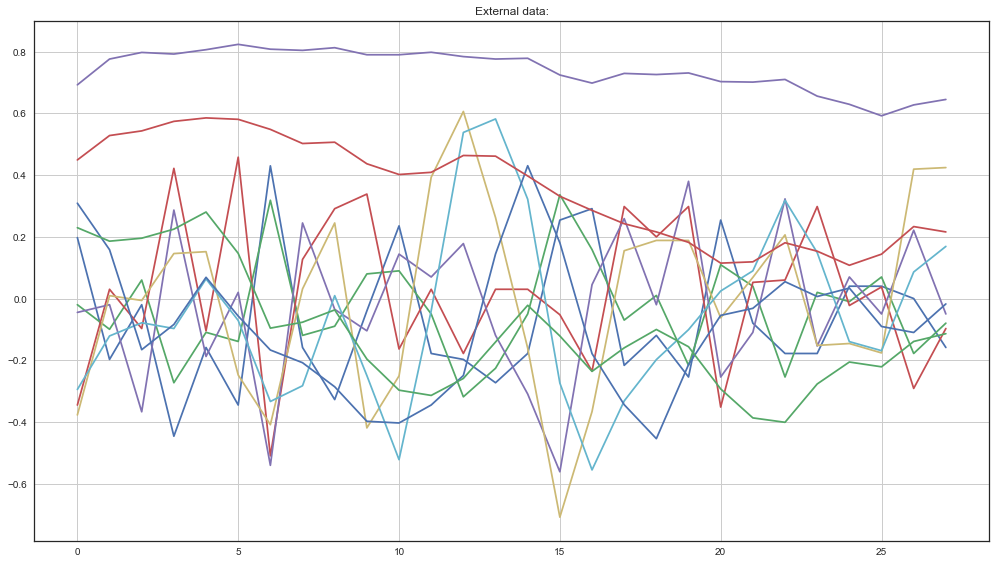

In [19]:
plt.figure(num=1, figsize=(14, 8))
plt.title('External data:')
plt.grid(True)

_ = plt.plot(data[-1, :, :])
#     plt.legend()
plt.tight_layout()

In [ ]:
env.close()

In [ ]:
data.shape

In [ ]:
_ = plt.hist(data[-1, :, :], bins=100)

In [ ]:
adf_roll = []
for i in range(data.shape[1]):
    adf_roll.append(adfuller(data[:, i, 0], autolag='AIC')[0])
    
plt.plot(np.asarray(adf_roll))
plt.plot(data[-1, :, 0]*10 -3)

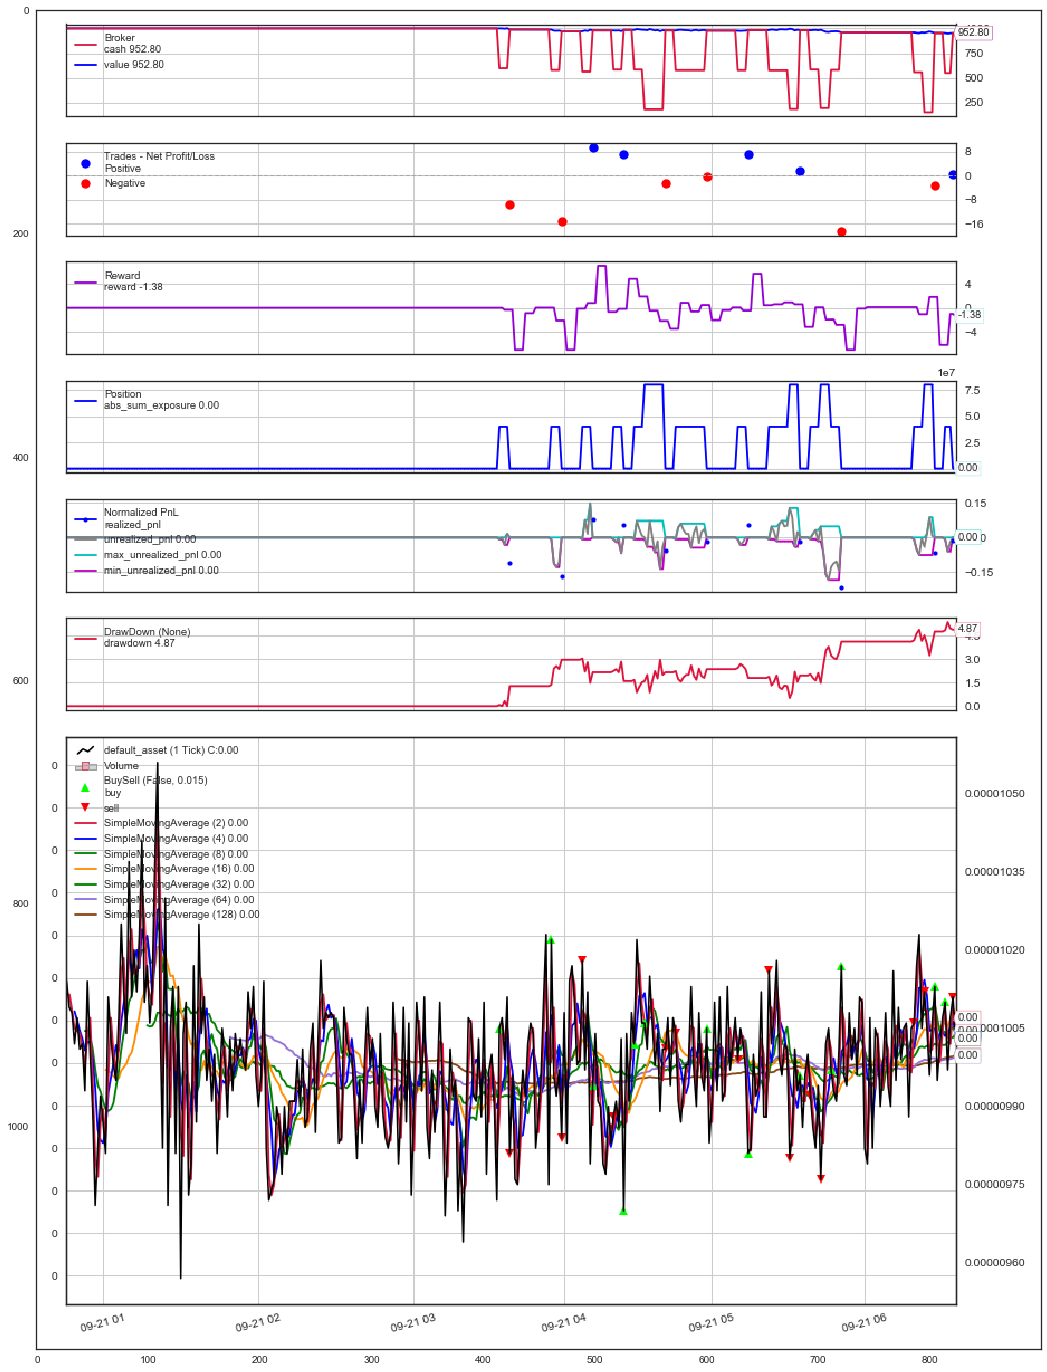

In [24]:
plt.figure(num=1, figsize=(18, 25))
_ = plt.imshow(image)